## Notebook to Examine clusters created from DBScans and KMeans

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

##### reading in the labels from the clustering analysis 

In [2]:
c_df = pd.read_csv('labels_clustering.csv')

In [7]:
c_df.head(4)

,patient_id,DBSCAN_label,KMeans
0,25312,0,3
1,59342,0,3
2,50777,-1,4
3,46918,-1,0


In [9]:
c_df.shape

(91713, 3)

In [5]:
%store -r wids

In [10]:
wids.shape

(91713, 301)

In [12]:
labeled_df = wids.merge(c_df, on = 'patient_id', how = 'left')
labeled_df.head(2)

,patient_id,encounter_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,spo2_min_change,sysbp_max_change,sysbp_min_change,temp_max_change,temp_min_change,wbc_max_change,wbc_min_change,apache_3j_diagnosis_desc,DBSCAN_label,KMeans
0,25312,66154,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,42.0,-0.4,0.3,NaN,NaN,Sepsis_of_urinary_tract_origin,0,3
1,59342,114252,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,-64.0,4.0,0.0,1.2,-10.6,0.0,Respiratory_arrest,0,3


In [26]:
list(labeled_df.columns)

['patient_id',
 'encounter_id',
 'hospital_id',
 'hospital_death',
 'age',
 'bmi',
 'elective_surgery',
 'ethnicity',
 'gender',
 'height',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'pre_icu_los_days',
 'readmission_status',
 'weight',
 'albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_respra

### Examining summary statistics of the cluster analysis 
- looked at number of patients, age, median, elective, top gender, top ethnicity, and top diagnosis 

In [24]:
labeled_df.groupby(['DBSCAN_label','hospital_death']).agg(
    num_patients = ('patient_id','nunique'),
    median_age = ('age','median'),
    median_bmi =('bmi','median'),
    top_elective =('elective_surgery',lambda x: x.value_counts(dropna=False).index[0] ),
    top_gender =('gender',lambda x: x.value_counts(dropna=False).index[0]),
    top_ethnicity =('ethnicity',lambda x: x.value_counts(dropna=False).index[0]),
    top_apache_3j_diagnosis_desc =('apache_3j_diagnosis_desc',lambda x: x.value_counts(dropna=False).index[0])
    
)


num_patients  median_age  median_bmi  \
DBSCAN_label hospital_death                                         
-1           0                      52701        58.0   29.014391   
             1                       5610        69.0   27.270568   
 0           0                      30921        70.0   26.880273   
             1                       2294        74.0   25.995912   
 1           0                         50        55.0   29.743746   
 2           0                         43        87.0   23.215788   
             1                          7        87.0   22.881253   
 3           0                         37        51.0   25.234375   
             1                          2        50.5   24.854656   
 4           0                         46        74.0   31.712448   
             1                          2        74.0   31.980525   

                             top_elective top_gender     top_ethnicity  \
DBSCAN_label hospital_death                                              
-1           0                          0          M         Caucasian   
             1                          0          M         Caucasian   
 0           0                          0          M         Caucasian   
             1                          0          M         Caucasian   
 1           0                          0          M         Caucasian   
 2           0                          0          M         Caucasian   
             1                          0          F         Caucasian   
 3           0                          0          M         Caucasian   
             1                          0          F  African_American   
 4           0                          0          M         Caucasian   
             1                          0          M     Other_Unknown   

                            top_apache_3j_diagnosis_desc  
DBSCAN_label hospital_death                               
-1           0                Sepsis__other_than_urinary  
             1                Sepsis__other_than_urinary  
 0           0                Sepsis__other_than_urinary  
             1                Sepsis__other_than_urinary  
 1           0               Acute_myocardial_infarction  
 2           0                  Congestive_heart_failure  
             1                Sepsis__other_than_urinary  
 3           0                  Other_neurologic_disease  
             1                             Drug_overdose  
 4           0                        Rhythm_disturbance  
             1                Sepsis__other_than_urinary

It looks clustering struggles to find groups of adequate size. However, something interesting to note is that it appears that most of the diagnosis that comes from apache 3j is Sepis_other_than_urinary. This appears to be the most common diagnosis for why people come to the ICU. That means that for both survival and death groups, the most common diagnosis is Sepis_other_than_urinary however there vitals do not look distinctly different. This means that our model struggles to find meaningful distinctions between our variables in the model. 

In [43]:
 t = wids.groupby(['apache_3j_diagnosis_desc'])['hospital_death'].value_counts().reset_index(name = 'counts').sort_values(by = 'counts',ascending = False)

In [46]:
pd.set_option('display.max_rows', 200)

In [47]:
t

,apache_3j_diagnosis_desc,hospital_death,counts
176,Sepsis__other_than_urinary,0,7342
0,Acute_myocardial_infarction,0,4159
44,Drug_overdose,0,3736
170,Rhythm_disturbance,0,3720
124,Other_cardiovascular_disease,0,3502
182,Stroke,0,3440
36,Coronary_artery_bypass_grafts__________,0,2911
34,Congestive_heart_failure,0,2637
178,Sepsis_of_urinary_tract_origin,0,2544
56,GI_bleeding___ulcer_laceration,0,2402


In [50]:
cmat = wids[wids['apache_3j_diagnosis_desc'] == 'Sepsis__other_than_urinary'].corr()

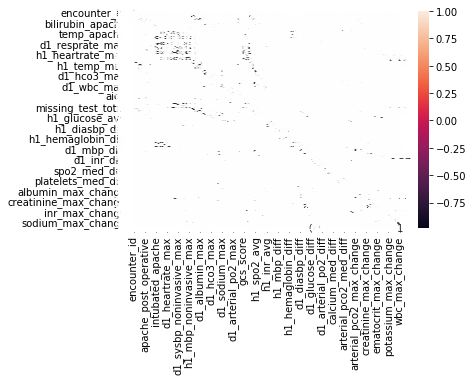

In [53]:
sns.heatmap(cmat,annot=True)

The most common predictors of Sepsis__other_than_urinary temp_apache, d1_resprate, h1_heartrate 

In [54]:
labeled_df.groupby(['DBSCAN_label','hospital_death']).agg(
    num_patients = ('patient_id','nunique'),
    median_age = ('age','median'),
    median_bmi =('bmi','median'),
    top_elective =('elective_surgery',lambda x: x.value_counts(dropna=False).index[0] ),
    top_gender =('gender',lambda x: x.value_counts(dropna=False).index[0]),
    top_ethnicity =('ethnicity',lambda x: x.value_counts(dropna=False).index[0]),
    top_apache_3j_diagnosis_desc =('apache_3j_diagnosis_desc',lambda x: x.value_counts(dropna=False).index[0]),
    median_temp_apache = ('temp_apache', 'median'),
    median_heartrate_max = ('h1_heartrate_max','median'),
    median_billirubin_apache = ('bilirubin_apache','median')
    
)

num_patients  median_age  median_bmi  \
DBSCAN_label hospital_death                                         
-1           0                      52701        58.0   29.014391   
             1                       5610        69.0   27.270568   
 0           0                      30921        70.0   26.880273   
             1                       2294        74.0   25.995912   
 1           0                         50        55.0   29.743746   
 2           0                         43        87.0   23.215788   
             1                          7        87.0   22.881253   
 3           0                         37        51.0   25.234375   
             1                          2        50.5   24.854656   
 4           0                         46        74.0   31.712448   
             1                          2        74.0   31.980525   

                             top_elective top_gender     top_ethnicity  \
DBSCAN_label hospital_death                                              
-1           0                          0          M         Caucasian   
             1                          0          M         Caucasian   
 0           0                          0          M         Caucasian   
             1                          0          M         Caucasian   
 1           0                          0          M         Caucasian   
 2           0                          0          M         Caucasian   
             1                          0          F         Caucasian   
 3           0                          0          M         Caucasian   
             1                          0          F  African_American   
 4           0                          0          M         Caucasian   
             1                          0          M     Other_Unknown   

                            top_apache_3j_diagnosis_desc  median_temp_apache  \
DBSCAN_label hospital_death                                                    
-1           0                Sepsis__other_than_urinary                36.5   
             1                Sepsis__other_than_urinary                36.3   
 0           0                Sepsis__other_than_urinary                36.4   
             1                Sepsis__other_than_urinary                36.3   
 1           0               Acute_myocardial_infarction                36.3   
 2           0                  Congestive_heart_failure                36.5   
             1                Sepsis__other_than_urinary                36.2   
 3           0                  Other_neurologic_disease                36.4   
             1                             Drug_overdose                36.3   
 4           0                        Rhythm_disturbance                36.4   
             1                Sepsis__other_than_urinary                36.4   

                             median_heartrate_max  median_billirubin_apache  
DBSCAN_label hospital_death                                                  
-1           0                               93.0                      0.60  
             1                              104.0                      0.90  
 0           0                               84.0                      0.60  
             1                               89.0                      0.80  
 1           0                               73.0                      0.55  
 2           0                               95.0                      1.10  
             1                              102.0                      0.70  
 3           0                               94.5                      0.45  
             1                              106.5                       NaN  
 4           0                               68.0                      0.55  
             1                               57.0                      1.00

In [ ]:
wids['bill']

In [57]:
# is there a difference in the billrubin 
surv = wids[(wids['apache_3j_diagnosis_desc'] == 'Sepsis__other_than_urinary') & wids['hospital_death'] == 0]['bilirubin_apache'].mean()
died = wids[(wids['apache_3j_diagnosis_desc'] == 'Sepsis__other_than_urinary') & wids['hospital_death'] == 1]['bilirubin_apache'].mean()

In [59]:
# Survived
wids[(wids['apache_3j_diagnosis_desc'] == 'Sepsis__other_than_urinary') & wids['hospital_death'] == 0] \
['bilirubin_apache'].describe()

count    32678.000000
mean         1.105789
std          2.037294
min          0.100000
25%          0.400000
50%          0.600000
75%          1.000000
max         51.000000
Name: bilirubin_apache, dtype: float64

In [58]:
# Died
wids[(wids['apache_3j_diagnosis_desc'] == 'Sepsis__other_than_urinary') & wids['hospital_death'] == 1] \
['bilirubin_apache'].describe()

count    901.000000
mean       2.668535
std        4.678128
min        0.100000
25%        0.600000
50%        1.100000
75%        2.400000
max       36.000000
Name: bilirubin_apache, dtype: float64

there a few variables where we see a distinct different for the same diagnosis 